# Импорт библиотек

In [5]:
import os
import shutil
import random
import time
import cv2
import math

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet101, InceptionV3
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from sklearn.metrics import confusion_matrix
from keras_flops import get_flops

from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Глобальные переменные

In [ ]:
RAW_DATASET_PATH = "data/raw/"
RESULTS_CSV = "data/evaluation_results.csv"
TARGET_SIZE = (224, 224)
BATCH_SIZE = 16

MODELS = [
        'VGG16', 'VGG19', 'ResNet50', 'ResNet101',
        'MobileNetV3Small', 'MobileNetV3Large', 
        'EfficientNetV2S', 'EfficientNetV2M', 'EfficientNetV2L'
    ]

# Вывод случайных изображений

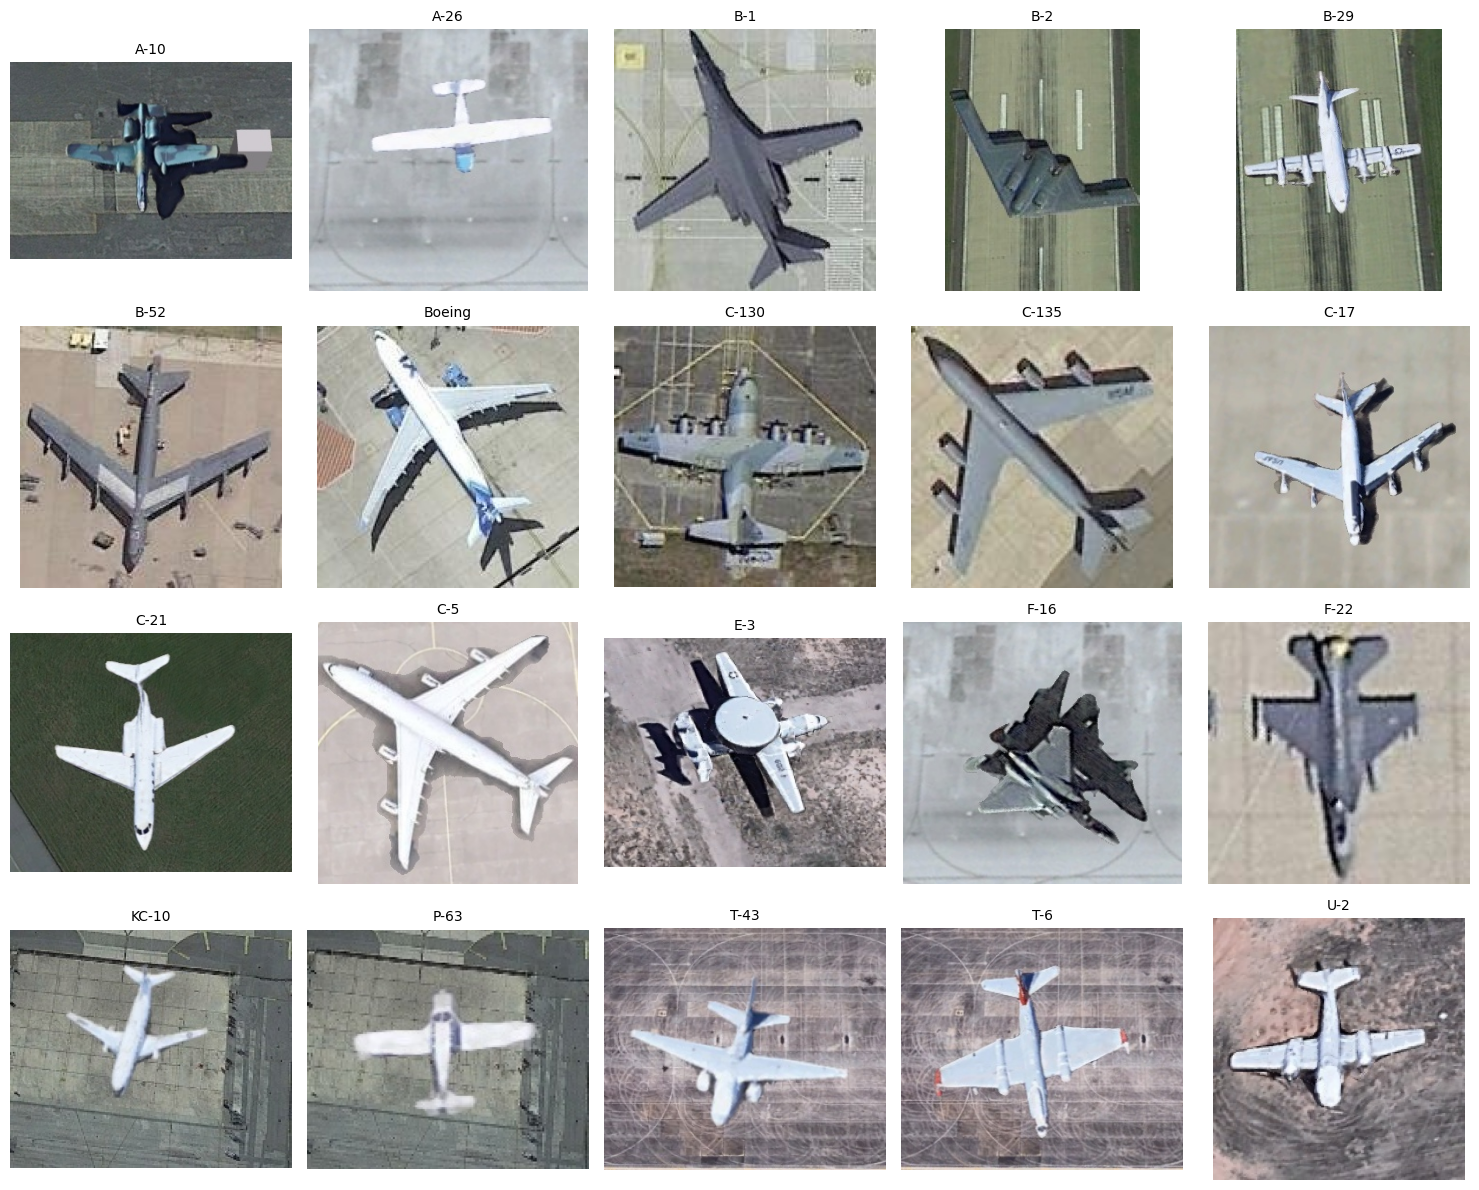

In [3]:
# Получаем список классов (папок)
classes = sorted(os.listdir(RAW_DATASET_PATH))
n_classes = len(classes)

# Определяем количество столбцов и строк для сетки
cols = 5
rows = math.ceil(n_classes / cols)

# Создаем фигуру и оси
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()

# Для каждого класса выбираем случайное изображение и отображаем его
for i, class_name in enumerate(classes):
    class_path = os.path.join(RAW_DATASET_PATH, class_name)
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)
    
    # Чтение и преобразование изображения
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    axes[i].imshow(image)
    axes[i].set_title(class_name, fontsize=10)
    axes[i].axis("off")

# Отключаем оси для пустых подграфиков, если они есть
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# Определение среднего размера изображения

In [4]:
def calculate_average_image_size(dataset_path):
    total_width, total_height, image_count = 0, 0, 0
    
    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                try:
                    with Image.open(image_path) as img:
                        width, height = img.size
                        total_width += width
                        total_height += height
                        image_count += 1
                except Exception as e:
                    print(f"Ошибка при обработке файла {image_path}: {e}")
    
    if image_count == 0:
        return (0, 0)  # Нет изображений
    
    average_width = total_width / image_count
    average_height = total_height / image_count
    return average_width, average_height

average_size = calculate_average_image_size(RAW_DATASET_PATH)
print(f"Средний размер изображений: {average_size[0]:.2f}x{average_size[1]:.2f}")


Средний размер изображений: 218.80x206.47


# Создание датасетов

In [6]:
# Собираем датафрейм с путями к изображениям и метками
rows = []
for class_name in os.listdir(RAW_DATASET_PATH):
    class_dir = os.path.join(RAW_DATASET_PATH, class_name)
    if not os.path.isdir(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            rows.append({
                'filename': os.path.join(class_name, fname),
                'class': class_name
            })
            
df = pd.DataFrame(rows)

# Разделение на train+val и test
df_trainval, df_test = train_test_split(df,
                                        test_size=0.25,
                                        stratify=df['class'],
                                        random_state=42)

# Из trainval делаем train и validation
df_train, df_val = train_test_split(df_trainval,
                                    test_size=0.20,   # 20% от 75% = 15% всего
                                    stratify=df_trainval['class'],
                                    random_state=42)

print(f"Количество изображений в train:      {len(df_train)}")
print(f"Количество изображений в validation: {len(df_val)}")
print(f"Количество изображений в test:       {len(df_test)}")

# Генератор без нормализации
datagen = ImageDataGenerator()

train_gen = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=RAW_DATASET_PATH,
    x_col='filename',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=RAW_DATASET_PATH,
    x_col='filename',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_gen = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=RAW_DATASET_PATH,
    x_col='filename',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Количество изображений в train:      5752
Количество изображений в validation: 1439
Количество изображений в test:       2398
Found 5752 validated image filenames belonging to 20 classes.
Found 1439 validated image filenames belonging to 20 classes.
Found 2398 validated image filenames belonging to 20 classes.


# Создание и обучение моделей

In [ ]:
# Функция загрузки и компиляции модели
def load_and_compile_model(model_name, input_shape=(224, 224, 3), num_classes=20):
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet101':
        base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'MobileNetV3Small':
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'MobileNetV3Large':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'EfficientNetV2S':
        base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'EfficientNetV2M':
        base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'EfficientNetV2L':
        base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Компиляция модели с метриками Top-1, Top-2 и Top-3 Accuracy
    model.compile(optimizer=Adam(), 
                  loss=CategoricalCrossentropy(), 
                  metrics=[
                      tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top_1_accuracy'),
                      tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
                      tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
                  ])
    return model

# Функция обучения модели
def train_model(model, train_generator, validation_generator, model_name):
    csv_logger = CSVLogger(f'logs\{model_name}_imagenet_training_log.csv', append=True)
    
    checkpoint = ModelCheckpoint(
        filepath=fr'data\result_models\{model_name}_best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_delta=1e-4,
        cooldown=2,
        min_lr=1e-7
    )
    
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[csv_logger, checkpoint, reduce_lr]
    )
    return history

# Функция для вычисления метрик
def evaluate_model(model, test_generator, model_name):
    # Рассчитываем среднее время инференса
    inference_times = []
    for _ in range(len(test_generator)):
        start_time = time.time()
        X_test_batch, _ = test_generator.next()  # Получаем следующий батч
        model.predict(X_test_batch, verbose=0)
        inference_times.append(time.time() - start_time)
    avg_inference_time = np.mean(inference_times)
    
    # Оценка модели и извлечение метрик
    results = model.evaluate(test_generator, verbose=0)
    metric_names = model.metrics_names
    loss = results[0]
    top_1 = results[metric_names.index('top_1_accuracy')]
    top_2 = results[metric_names.index('top_2_accuracy')]
    top_3 = results[metric_names.index('top_3_accuracy')]
    
    return {
        'Model': model_name,
        'Loss': loss,
        'Top-1 Accuracy': top_1,
        'Top-2 Accuracy': top_2,
        'Top-3 Accuracy': top_3,
        'Avg Inference Time (s)': avg_inference_time
    }


def main():    
    for model_name in MODELS:
        print(f"Training {model_name}")
    
        model = load_and_compile_model(model_name)
        train_model(model, train_gen, val_gen, model_name)
        
        # Загрузка лучшей версии модели
        best_model = tf.keras.models.load_model(fr'data\result_models\{model_name}_best_model.h5')
        
        # Оценка модели
        print(f"Evaluating {model_name}")
        metrics = evaluate_model(best_model, test_gen, model_name)
        
        # Вывод результатов в консоль
        for key, value in metrics.items():
            print(f"{key}: {value}")

        # Сохранение результатов после каждой модели (результаты добавляются, если файл существует)
        metrics_df = pd.DataFrame([metrics])
        if not os.path.isfile(RESULTS_CSV):
            metrics_df.to_csv(RESULTS_CSV, index=False, mode='w')
        else:
            metrics_df.to_csv(RESULTS_CSV, index=False, header=False, mode='a')
        print(f"Results for {model_name} saved to {RESULTS_CSV}\n")
        
main()


Training VGG16
Epoch 1/50
358/360 [============================>.] - ETA: 0s - loss: 3.6802 - top_1_accuracy: 0.3657 - top_2_accuracy: 0.5044 - top_3_accuracy: 0.5846
Epoch 1: val_loss improved from inf to 1.57554, saving model to data\result_models\VGG16_best_model.h5
360/360 [==============================] - 15s 40ms/step - loss: 3.6743 - top_1_accuracy: 0.3663 - top_2_accuracy: 0.5049 - top_3_accuracy: 0.5854 - val_loss: 1.5755 - val_top_1_accuracy: 0.5872 - val_top_2_accuracy: 0.7262 - val_top_3_accuracy: 0.8103 - lr: 0.0010
Epoch 2/50
359/360 [============================>.] - ETA: 0s - loss: 1.0679 - top_1_accuracy: 0.6965 - top_2_accuracy: 0.8215 - top_3_accuracy: 0.8893
Epoch 2: val_loss improved from 1.57554 to 1.03655, saving model to data\result_models\VGG16_best_model.h5
360/360 [==============================] - 16s 44ms/step - loss: 1.0673 - top_1_accuracy: 0.6965 - top_2_accuracy: 0.8216 - top_3_accuracy: 0.8894 - val_loss: 1.0366 - val_top_1_accuracy: 0.6956 - val_top_

# Графики

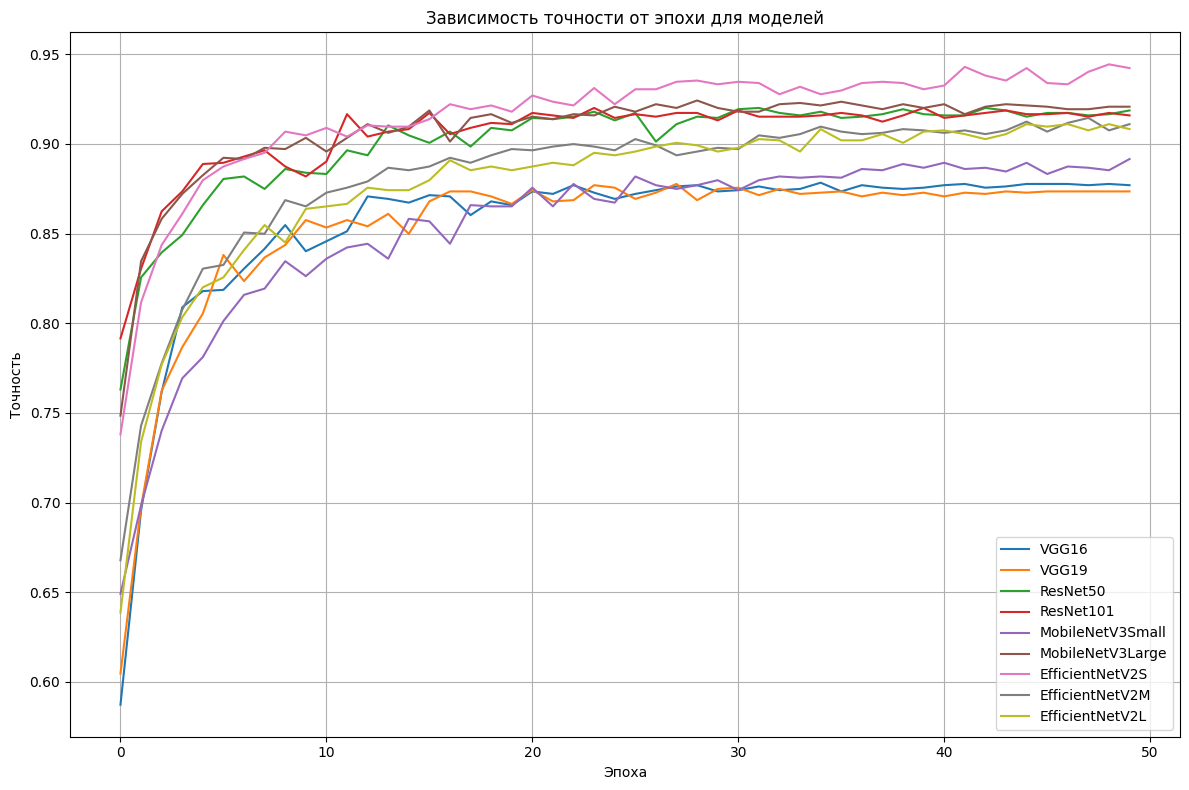

In [15]:
plt.figure(figsize=(12, 8))

# Для каждой модели читаем CSV лог и строим график точности по эпохам
for model in MODELS:
    filename = f"logs/{model}_imagenet_training_log.csv"
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        plt.plot(df['epoch'], df['val_top_1_accuracy'], label=model)

plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Зависимость точности от эпохи для моделей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

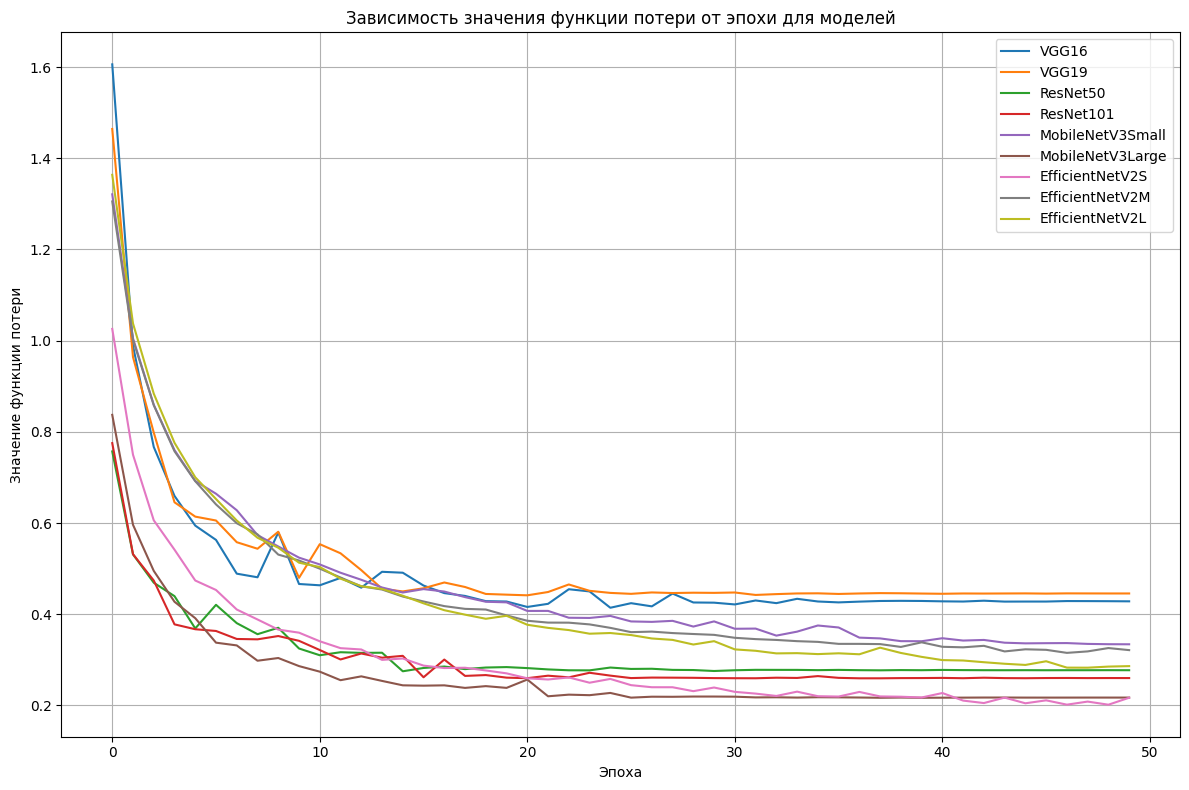

In [8]:
plt.figure(figsize=(12, 8))

# Для каждой модели читаем CSV лог и строим график top_1_accuracy по эпохам
for model in MODELS:
    filename = f"logs/{model}_imagenet_training_log.csv"
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        plt.plot(df['epoch'], df['val_loss'], label=model)

plt.xlabel('Эпоха')
plt.ylabel('Значение функции потери')
plt.title('Зависимость значения функции потери от эпохи для моделей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

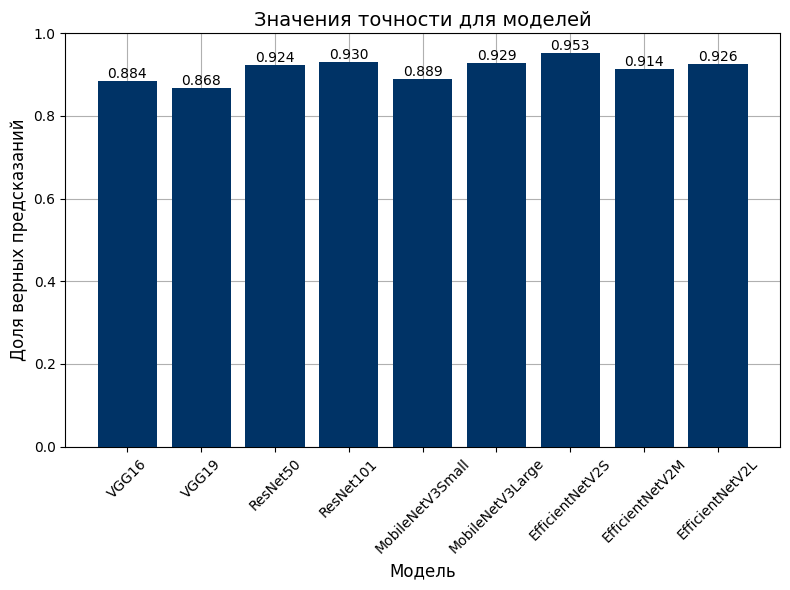

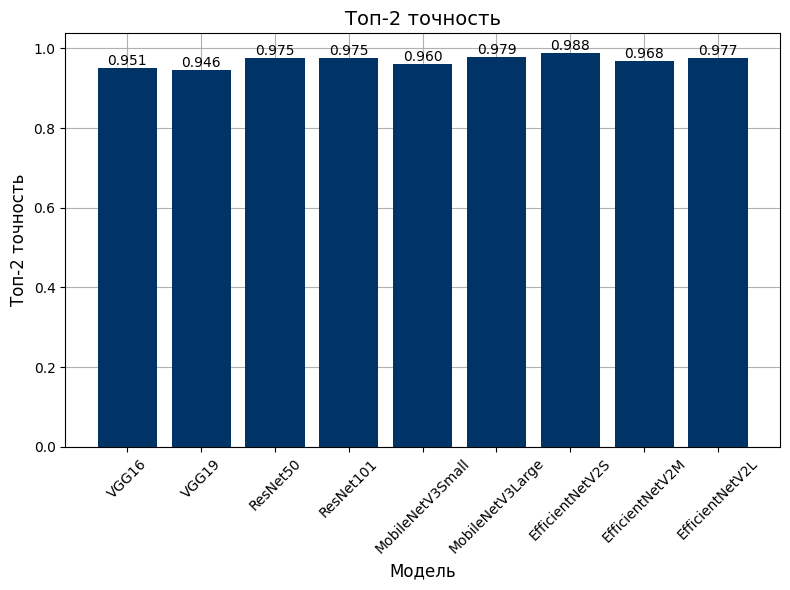

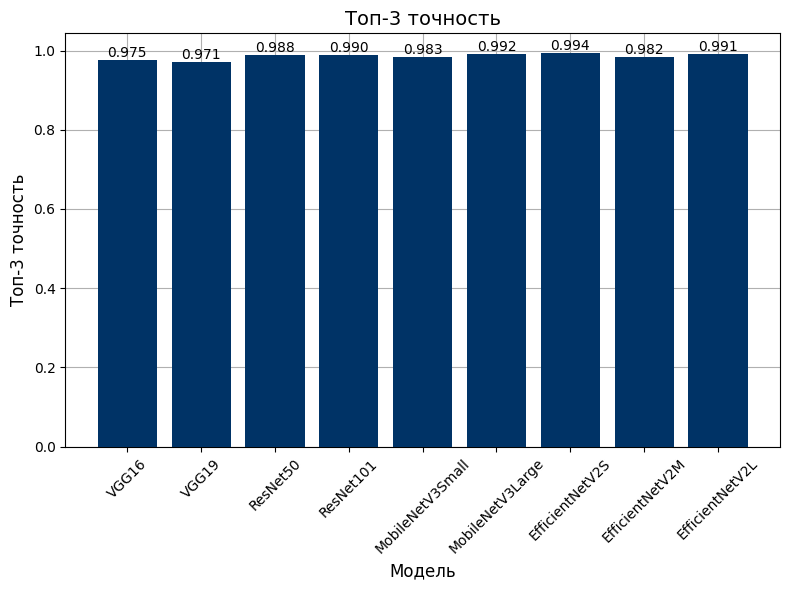

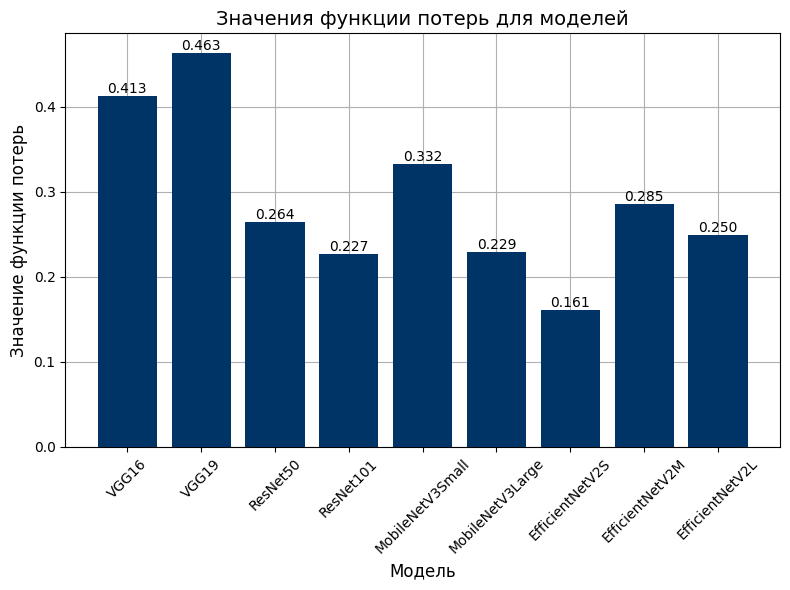

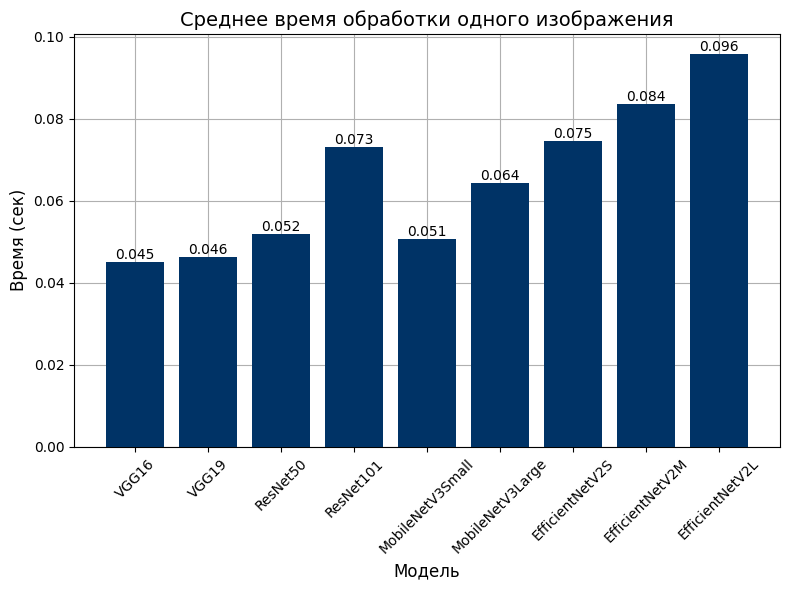

In [27]:
# Загрузка данных из CSV файла
df = pd.read_csv(RESULTS_CSV)

# Темно-синий цвет
dark_blue = "#003366"

# Функция для подписывания значений над столбцами
def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], f'{y[i]:.3f}', ha='center', va='bottom')  

# Построение barplot для Топ-1 точности 
plt.figure(figsize=(8, 6))
ax = plt.gca()
rects = plt.bar(df['Model'], df['Top-1 Accuracy'], color=dark_blue, zorder=3)
plt.title("Значения точности для моделей", fontsize=14)
plt.xlabel("Модель", fontsize=12)
plt.ylabel("Доля верных предсказаний", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1) 
plt.grid()
add_labels(df['Model'], df['Top-1 Accuracy'])
plt.tight_layout()
plt.show()

# Построение barplot для Топ-2 точности
plt.figure(figsize=(8, 6))
ax = plt.gca()
rects = plt.bar(df['Model'], df['Top-2 Accuracy'], color=dark_blue, zorder=3)
plt.title("Топ-2 точность", fontsize=14)
plt.xlabel("Модель", fontsize=12)
plt.ylabel("Топ-2 точность", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
add_labels(df['Model'], df['Top-2 Accuracy'])
plt.tight_layout()
plt.show()

# Построение barplot для Топ-3 точности
plt.figure(figsize=(8, 6))
ax = plt.gca()
rects = plt.bar(df['Model'], df['Top-3 Accuracy'], color=dark_blue, zorder=3)
plt.title("Топ-3 точность", fontsize=14)
plt.xlabel("Модель", fontsize=12)
plt.ylabel("Топ-3 точность", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
add_labels(df['Model'], df['Top-3 Accuracy'])
plt.tight_layout()
plt.show()

# Построение barplot для функции потерь
plt.figure(figsize=(8, 6))
ax = plt.gca()
rects = plt.bar(df['Model'], df['Loss'], color=dark_blue, zorder=3)
plt.title("Значения функции потерь для моделей", fontsize=14)
plt.xlabel("Модель", fontsize=12)
plt.ylabel("Значение функции потерь", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
add_labels(df['Model'], df['Loss'])
plt.tight_layout()
plt.show()

# Построение barplot для среднего времени инференса
plt.figure(figsize=(8, 6))
ax = plt.gca()
rects = plt.bar(df['Model'], df['Avg Inference Time (s)'], color=dark_blue, zorder=3)
plt.title("Среднее время обработки одного изображения", fontsize=14)
plt.xlabel("Модель", fontsize=12)
plt.ylabel("Время (сек)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
add_labels(df['Model'], df['Avg Inference Time (s)'])
plt.tight_layout()
plt.show()


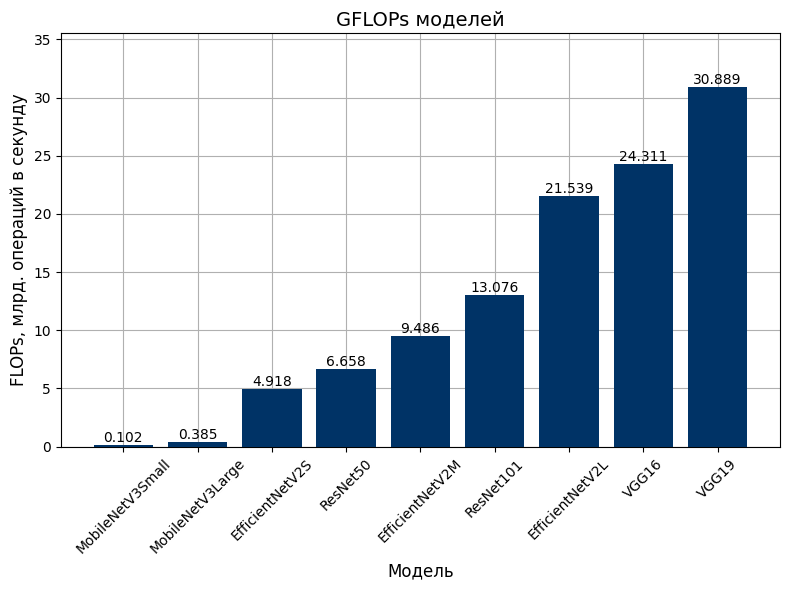

In [35]:
model_flops_pairs = []

for model_name in MODELS:
    model = load_and_compile_model(model_name)
    flops = get_flops(model, batch_size=1)
    gflops = flops / 1e9
    model_flops_pairs.append((model_name, gflops))

# Сортировка по GFLOPs (по возрастанию)
model_flops_pairs.sort(key=lambda x: x[1])

# Транспонируем
sorted_models, sorted_gflops = zip(*model_flops_pairs)

# Построение графика
plt.figure(figsize=(8, 6))
ax = plt.gca()
rects = plt.bar(sorted_models, sorted_gflops, color=dark_blue, zorder=3)
plt.title("GFLOPs моделей", fontsize=14)
plt.xlabel("Модель", fontsize=12)
plt.ylabel("FLOPs, млрд. операций в секунду", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, max(sorted_gflops) * 1.15)
plt.grid(zorder=0)
add_labels(sorted_models, sorted_gflops)
plt.tight_layout()
plt.show() 

2398/2398 [==============================] - 62s 25ms/step


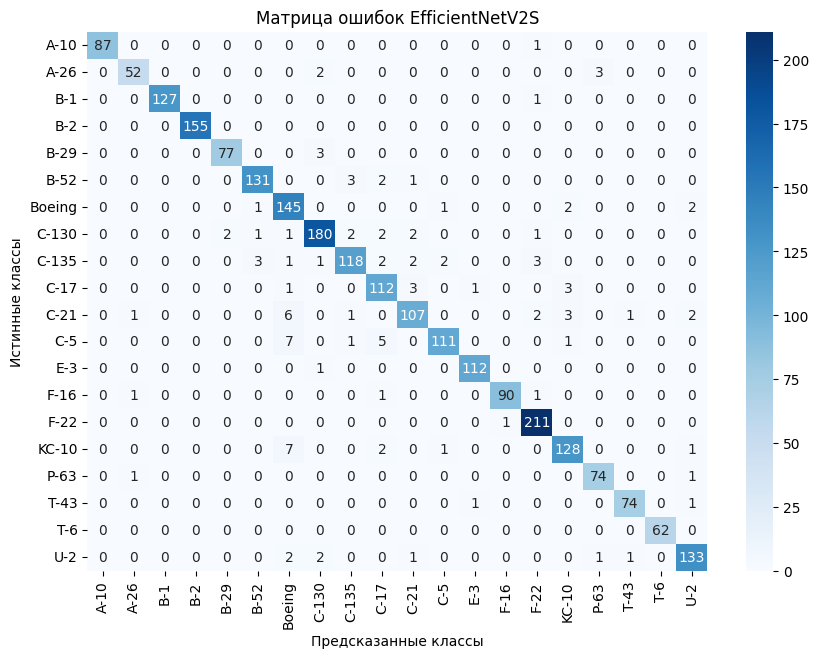

In [17]:
# Подгружаем модель из папки Result_models
best_model = tf.keras.models.load_model('data/result_models/EfficientNetV2S_best_model.h5')

# Получаем предсказания на тестовом наборе данных
y_pred_prob = best_model.predict(test_gen, steps=len(test_gen), verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

# Извлекаем истинные метки из генератора
y_true = test_gen.classes

# Получаем список названий классов
class_labels = list(test_gen.class_indices.keys())

# Вычисляем матрицу ошибок
cm = confusion_matrix(y_true, y_pred)

# Строим тепловую карту матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок EfficientNetV2S')
plt.show()

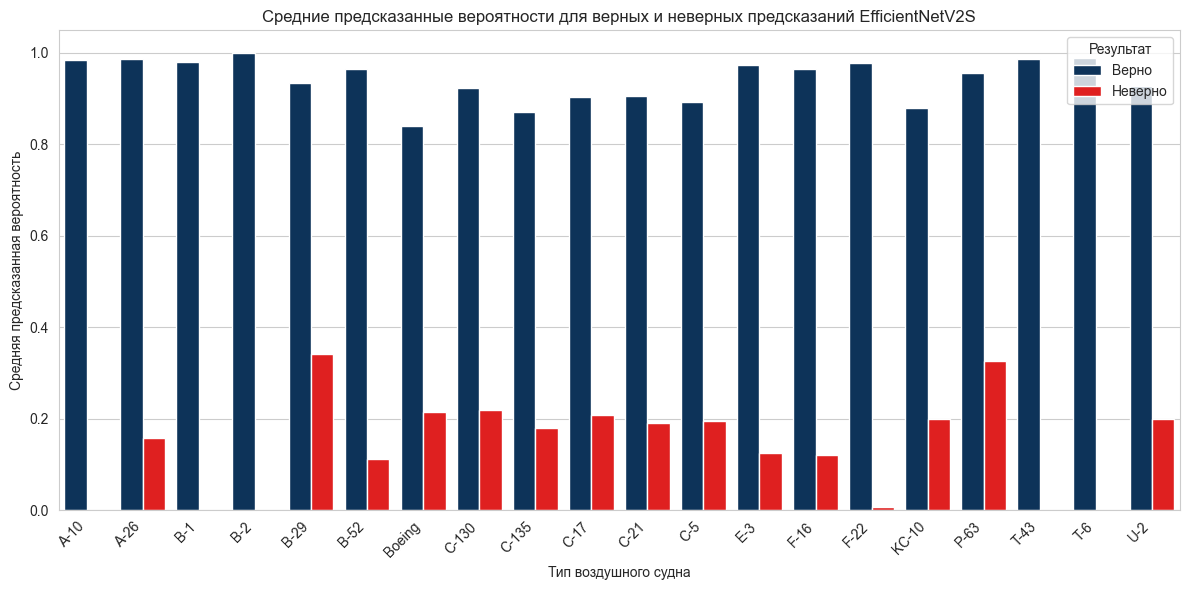

In [ ]:
# Для каждого класса собираем средние вероятности верных и неверных предсказаний
data = []
num_classes = len(class_labels)

for class_index in range(num_classes):
    idxs_for_class = np.where(y_true == class_index)[0]
    
    correct_probs = []
    incorrect_probs = []
    
    for j in idxs_for_class:
        prob_for_class = y_pred_prob[j, class_index]
        if y_pred[j] == class_index:
            correct_probs.append(prob_for_class)
        else:
            incorrect_probs.append(prob_for_class)
    
    mean_correct = np.mean(correct_probs) if correct_probs else 0.0
    mean_incorrect = np.mean(incorrect_probs) if incorrect_probs else 0.0
    
    data.append({
        'Тип ВС': class_labels[class_index],
        'Средняя вероятность': mean_correct,
        'Результат': 'Верно'
    })
    data.append({
        'Тип ВС': class_labels[class_index],
        'Средняя вероятность': mean_incorrect,
        'Результат': 'Неверно'
    })

# Шаг 6: Создаём DataFrame для визуализации
df = pd.DataFrame(data)

# Шаг 7: Строим столбчатую диаграмму
dark_blue = "#003366"

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x='Тип ВС',
    y='Средняя вероятность',
    hue='Результат',
    palette={'Верно': dark_blue, 'Неверно': 'red'}
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Тип воздушного судна')
plt.ylabel('Средняя предсказанная вероятность')
plt.title('Средние предсказанные вероятности для верных и неверных предсказаний EfficientNetV2S')
plt.legend(title='Результат', loc='best')
plt.tight_layout()
plt.show()

# Интерфейс

In [1]:
import sys
import os
import csv
import json
import numpy as np

from PyQt5.QtWidgets import (
    QApplication, QMainWindow, QWidget, QVBoxLayout, QPushButton,
    QLabel, QFileDialog, QSizePolicy
)
from PyQt5.QtGui import QPixmap, QIcon, QFont
from PyQt5.QtCore import Qt
from PyQt5.QtWidgets import QMessageBox

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

# Задаём целевой размер изображения для модели
TARGET_SIZE = (200, 200)

# Пути к файлам модели и иконки
MODEL_PATH = "Result_models/EfficientNetV2S_best_model.h5"
ICON_PATH = "icon.svg"

# Загрузка обученной модели
model = load_model(MODEL_PATH)

# Список классов для классификации
CLASSES = [
    'A-10', 'A-26', 'B-1', 'B-2', 'B-29', 'B-52', 'Boeing',
    'C-130', 'C-135', 'C-17', 'C-21', 'C-5', 'E-3', 'F-16',
    'F-22', 'KC-10', 'P-63', 'T-43', 'T-6', 'U-2'
]

class MainWindow(QMainWindow):
    """Основное окно приложения"""
    
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Классификатор самолётов по спутниковым снимкам")
        self.setMinimumSize(600, 500)
        self.setWindowIcon(QIcon(ICON_PATH))
        
        # Используется для хранения загруженного изображения в виде объекта QPixmap
        self.original_pixmap = None
        
        # Виджет для главного окна (в него помещаются все остальные виджеты)
        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)
        self.layout = QVBoxLayout(self.central_widget)
        
        # Виджет для отображения изображения
        self.image_label = QLabel()
        self.image_label.setAlignment(Qt.AlignCenter)
        self.image_label.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding) #Если пользователь увеличивает окно - метка растягивается
        self.layout.addWidget(self.image_label)
        
        # Кнопка загрузки одного изображения
        self.btn_load = QPushButton("Обработка одного изображения")
        self.btn_load.setFont(QFont("Arial", 14))
        self.btn_load.setSizePolicy(QSizePolicy.Fixed, QSizePolicy.Fixed)
        self.btn_load.clicked.connect(self.load_image)
        self.layout.addWidget(self.btn_load, alignment=Qt.AlignCenter)
        
        # Кнопка пакетной обработки
        self.btn_batch = QPushButton("Пакетная обработка изображений")
        self.btn_batch.setFont(QFont("Arial", 14))
        self.btn_batch.setSizePolicy(QSizePolicy.Fixed, QSizePolicy.Fixed)
        self.btn_batch.clicked.connect(self.process_folder)
        self.layout.addWidget(self.btn_batch, alignment=Qt.AlignCenter)
        
        # Метка для вывода результата
        self.result_label = QLabel("")
        self.result_label.setAlignment(Qt.AlignCenter)
        self.result_label.setFont(QFont("Arial", 16))
        self.result_label.setWordWrap(True)
        self.layout.addWidget(self.result_label)
        
        # Стилизация
        self.setStyleSheet("""
            QMainWindow { background-color: #f0f8ff; }
            QPushButton {
                background-color: #4682B4;
                color: white;
                padding: 10px 20px;
                border-radius: 10px;
            }
            QPushButton:hover { background-color: #5A9BD5; }
            QLabel { color: #333333; }
        """)

    def load_image(self):
        """Обрабатывает одно изображение"""

        # Выбор файла (сохранение пути до файла)
        file_path, _ = QFileDialog.getOpenFileName(
            self, "Выберите изображение", "",
            "Image Files (*.png *.jpg *.jpeg *.bmp);;All Files (*)"
        )
        if not file_path:
            return

        # Загрузка изображения в интерфейс
        self.original_pixmap = QPixmap(file_path)
        if self.original_pixmap.isNull():
            self.result_label.setText("Ошибка загрузки изображения.")
            return
        self.update_image_display()

        try:
            img = Image.open(file_path).convert('RGB').resize(TARGET_SIZE)
            arr = image.img_to_array(img)
            # Массив из формы (200, 200, 3) в форму (1, 200, 200, 3) 
            preds = model.predict(np.expand_dims(arr, axis=0))[0]
            top3 = preds.argsort()[::-1][:3]

            lines = []
            # Формирование строки с результатами
            for i, idx in enumerate(top3, start=1):
                label = CLASSES[idx] if idx < len(CLASSES) else "Неизвестный класс"
                conf = preds[idx] * 100
                lines.append(f"{i}. {label} ({conf:.2f}% уверенности)")
            self.result_label.setText("\n".join(lines))

        except Exception as e:
            self.result_label.setText(f"Ошибка: {e}")

    def process_folder(self):
        """Обрабатывает папку с изображениями"""

        # Выбор папки
        folder = QFileDialog.getExistingDirectory(self, "Выберите папку с изображениями")
        if not folder:
            return
        
        # Выбор формата и файла сохранения
        save_path, fmt = QFileDialog.getSaveFileName(
            self,
            "Сохранить результаты",
            "",
            "CSV (*.csv);;JSON (*.json)"
        )
        if not save_path:
            return

        # Проверка формата файла
        is_csv = fmt == "CSV (*.csv)"
        results = []
        
        # Инициализация информационного сообщения для результата
        msg = QMessageBox()
        msg.setIcon(QMessageBox.Information)
        msg.setWindowTitle("Информация")
        msg.setStandardButtons(QMessageBox.Ok)
        
        # Обработка всех изображений в папке
        for fname in os.listdir(folder):
            path = os.path.join(folder, fname)
            if not os.path.isfile(path) or not fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
                continue
            try:
                img = Image.open(path).convert('RGB').resize(TARGET_SIZE)
                arr = image.img_to_array(img)
                preds = model.predict(np.expand_dims(arr, axis=0))[0]
                top3 = preds.argsort()[::-1][:3]

                entry = {'filename': fname}
                for i, idx in enumerate(top3, start=1):
                    entry[f'top{i}'] = CLASSES[idx]
                    entry[f'conf{i}'] = round(float(preds[idx] * 100), 4)
                results.append(entry)

            except Exception as e:
                results.append({'filename': fname, 'error': str(e)})

        # Сохранение результатов
        try:
            # Сохранение в CSV
            if is_csv:
                with open(save_path, 'w', newline='', encoding='utf-8') as f:
                    writer = csv.DictWriter(f, fieldnames=sorted({k for r in results for k in r}))
                    writer.writeheader()
                    writer.writerows(results)

            # Сохранение в json
            else:
                with open(save_path, 'w', encoding='utf-8') as f:
                    json.dump(results, f, ensure_ascii=False, indent=2)
            msg.setText(f"Готово! Результаты сохранены в {save_path}")
            msg.exec_()

        except Exception as e:
            msg.setText(f"Ошибка при сохранении: {e}")
            msg.exec_()

    def update_image_display(self):
        """Обновляет отображение изображения в QLabel"""

        if self.original_pixmap:
            scaled = self.original_pixmap.scaled(
                self.image_label.width(),
                self.image_label.height(),
                Qt.KeepAspectRatio,
                Qt.SmoothTransformation
            )
            self.image_label.setPixmap(scaled)

    def resizeEvent(self, event):
        """Обрабатывает событие изменения размера окна"""

        self.update_image_display()


if __name__ == '__main__':
    app = QApplication.instance() or QApplication(sys.argv)
    window = MainWindow()
    window.show()
    sys.exit(app.exec_())


1/1 [==============================] - 0s 20ms/step


SystemExit: 0

C:\Users\MixRu\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
